In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install widgetsnbextension ipywidgets jupyterlab_widgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [3]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from itertools import product
from tqdm.notebook import tqdm
from typing import Optional

import warnings
from scipy.optimize import minimize, linprog, shgo

from pyqumo.fitting import fit_mern2, fit_acph2, fit_map_horvath05, optimize_lag1
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang, PhaseType, Distribution
from pyqumo.arrivals import MarkovArrival
from pyqumo.errors import BoundsError, RowSumError
from pyqumo.matrix import cbdiag

In [5]:
def fit_ph(m1: float, cv: float, skew: float) -> PhaseType:
    """
    Fit PH by either ACPH(2) or MERN(2) methods.
    """
    moments = np.asarray([m1, get_noncentral_m2(m1, cv), get_noncentral_m3(m1, cv, skew)])
    try:
        dist: Distribution = fit_acph2(moments, strict=True)
    except BoundsError:
        dist: Distribution = fit_mern2(moments, strict=False, max_shape_inc=1)
    return dist[0].as_ph()

def fit_map(ph: PhaseType, lag1: float) -> MarkovArrival:
    """
    Shortcut for fitting MAP
    """
    return fit_map_horvath05(ph, lag1)[0]

## Анализ максимального и минимального коэффициента автокорреляции

Первый эксперимент:

1) Построим простой PH по трем моментам
2) Вычислим для него минимальный и максимальный коэффициенты автокорреляции
3) Убедимся, что полученные решения определяют MAP-поток
4) Убедимся, что если построить MAP-представление исходного PH, у него автокорреляция будет нулевой

In [6]:
ph = fit_ph(1, 0.5, 2)
min_rho = optimize_lag1(ph, optype='min')
max_rho = optimize_lag1(ph, optype='max')

print('min: ', min_rho.fun)
print('max: ', max_rho.fun)

# Validate D0, D1 describe well-defined MAPs:
MarkovArrival(ph.s, min_rho.x.reshape((ph.order, ph.order)).T)
MarkovArrival(ph.s, max_rho.x.reshape((ph.order, ph.order)).T)

print('real: ', MarkovArrival.phase_type(ph.s, ph.init_probs).lag(1))
print(optimize_lag1(ph, optype='min').fun)

min:  -0.019604337939179466
max:  0.2877932070414288
real:  8.88178419700126e-16
-0.017927529895578314


## Генерация случайного MAP-потока для заданного PH

Определим функцию, которая генерирует MAP со случайной матрицей D1, но так, чтобы у результата коэффициент автокорреляции был не меньше (по модулю) заданного значения.
Для этого будем выбирать случайные элементы D1 и заполнять их числами, пока сумма с элементами соответствующих строк D0 не будет нулевой.

In [7]:
def generate_random_map(ph: PhaseType, max_iters: int = 1000, min_lag_abs: float = .1):
    """
    Generate random MAP for the given stationary PH with lag-1 autocorrelation
    not less then the given value.
    """
    best_solution = MarkovArrival.phase_type(ph.s, ph.init_probs)
    best_lag1 = best_solution.lag(1)
    print(f"- original lag-1 is {best_lag1:.5f}")
    iteration = 0
    while iteration < max_iters and abs(best_lag1) < min_lag_abs:
        m = ph.order
        d1 = np.zeros((m, m))
        for i in range(m):
            delta = -sum(ph.s[i])
            if delta < 1e-10:
                continue
            columns = list(range(m))
            while delta > 0:
                j = np.random.choice(columns)
                columns.remove(j)
                d1[i, j] = np.random.uniform(0, delta) if columns else delta
                delta -= d1[i, j]
        new_solution = MarkovArrival(ph.s, d1)
        new_lag1 = new_solution.lag(1)
        if abs(new_lag1) > abs(best_lag1):
            print(f"- update: new lag-1 is {new_lag1:.5f}")
            best_solution = new_solution
            best_lag1 = new_lag1
        iteration += 1
    return best_solution

ph = fit_ph(1, 3, 4)
markov_arrival = generate_random_map(ph)
print("MAP lag-1 correlation: ", markov_arrival.lag(1))
print("Matrices")
with np.printoptions(precision=3, suppress=True):
    print("+ D0:")
    print(markov_arrival.d0)
    print("+ D1:")
    print(markov_arrival.d1)

- original lag-1 is 0.00000
- update: new lag-1 is 0.00954
- update: new lag-1 is 0.18680
MAP lag-1 correlation:  0.1868044568950211
Matrices
+ D0:
[[-86.706  86.706   0.      0.   ]
 [  0.    -86.706   0.      0.   ]
 [  0.      0.     -0.294   0.294]
 [  0.      0.      0.     -0.294]]
+ D1:
[[ 0.     0.     0.     0.   ]
 [ 0.14  66.302  1.463 18.801]
 [ 0.     0.     0.     0.   ]
 [ 0.01   0.047  0.032  0.205]]


## Диапазоны изменений коэффициентов автокорреляции первого порядка

Построим набор PH-распределений для сетки $(cv - 1/cv, \gamma)$ и вычислим для этих распределений минимальный и максимальный коэффициенты автокорреляции.

In [8]:
def x2cv(x: float) -> float:
    """Get CV value from c-1/c value.
    """
    return (x + pow(x**2 + 4, 0.5)) / 2

In [9]:
GRID_SIZE = 20
X = np.linspace(-2.5, 10, GRID_SIZE)  # c - 1/c values
Y = np.linspace(0, 10, GRID_SIZE)  # gamma (skewness) values, not all feasible
CV = np.asarray([x2cv(x) for x in X])
PLANE_SHAPE = (GRID_SIZE, GRID_SIZE)
COORDS = list(product(range(GRID_SIZE), range(GRID_SIZE)))
MEAN = 1.0

In [10]:
phs = [[fit_ph(MEAN, cv, y) if y > x else None for (x, cv) in zip(X, CV)] for y in tqdm(Y)]

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
lowest = [[optimize_lag1(ph, optype='min', n_iters=3).fun if ph and ph.order < 10 else None for ph in row] for row in tqdm(phs)]

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
highest = [[optimize_lag1(ph, optype='max', n_iters=3).fun if ph and ph.order < 10 else None for ph in row] for row in tqdm(phs)]

  0%|          | 0/20 [00:00<?, ?it/s]

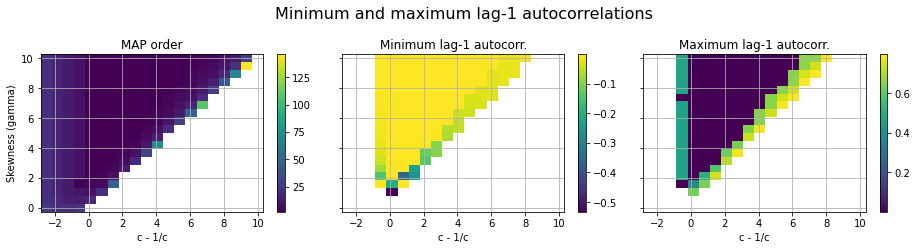

In [15]:
def plot_corr(lowest, highest, title="", y_size=5):
    orders = np.zeros(shape=PLANE_SHAPE)
    for (i, j) in COORDS:
        if phs[i][j] is None:
            orders[i][j] = None
        else:
            orders[i][j] = phs[i][j].order
        if lowest[i][j] is None:
            lowest[i][j] = np.nan
        if highest[i][j] is None:
            highest[i][j] = np.nan

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, y_size), ncols=3, nrows=1, sharey=True)
    im1 = ax1.pcolormesh(X, Y, orders)
    im2 = ax2.pcolormesh(X, Y, lowest)
    im3 = ax3.pcolormesh(X, Y, highest)
    
    fig.suptitle(title, fontsize=16) 
    ax1.set_title('MAP order')
    ax2.set_title('Minimum lag-1 autocorr.')
    ax3.set_title('Maximum lag-1 autocorr.')
    
    ax1.set_ylabel('Skewness (gamma)')
    
    for im, ax in zip((im1, im2, im3), (ax1, ax2, ax3)):
        fig.colorbar(im, ax=ax)
        ax.set_xlabel('c - 1/c')
        ax.grid()
        
    plt.tight_layout()    

#
# Plot original hyper-Erlang distributions without optimizations of ratios or probabilities.
#
plot_corr(lowest, highest, "Minimum and maximum lag-1 autocorrelations", y_size=3.5)
# plt.savefig('image.png')